In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("incl/")

import ELPH_utils
import ELPH_Scaler
import ELPH_Optimizer

from ELPH_NVAR import SVDNVAR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# runs = ELPH_utils.load_runs()

# runs_w002 = ELPH_utils.load_runs(filename='../runs_w0.02.npz')
# runs_w003 = ELPH_utils.load_runs(filename='../runs_w0.03.npz')
# runs_w01 = ELPH_utils.load_runs(filename='../runs_w0.1.npz')

# runs = runs[:] + runs_w002[:] + runs_w003 + runs_w01


runs = ELPH_utils.load_runs(filename='../runs_rand_inits.npz')


n_runs = len(runs)
n_kmax = runs[0].shape[0]

print(n_runs, 'loaded with n_kmax =', n_kmax)

# for k in range(len(runs)):
#     runs[k] = runs[k][:,:200:2]

500 loaded with n_kmax = 80


runs[0] shape:  (80, 400)


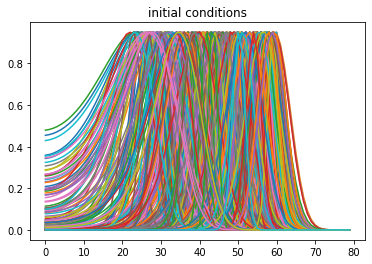

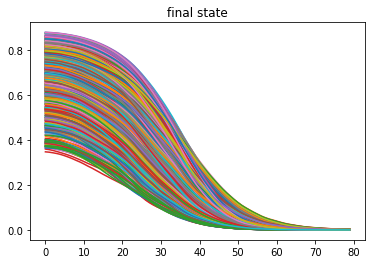

In [12]:
print('runs[0] shape: ', runs[0].shape)

for k in range(n_runs):
    plt.plot(runs[k][:,0])

plt.title('initial conditions')
plt.show()


for k in range(n_runs):
    plt.plot(runs[k][:,-1])

plt.title('final state')
plt.show()

rdim:  20
n_VAR_steps:  2
NVAR_p:  2
VAR state shape:  (40, 199500)
NVAR state shape:  (861, 199500)
target shape:  (20, 199500)
weights shape:  (861, 20)


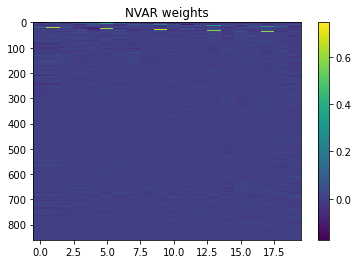

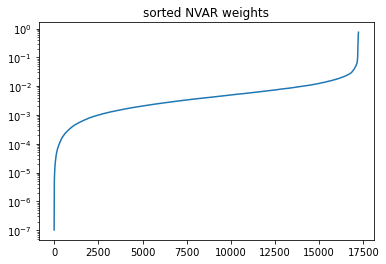

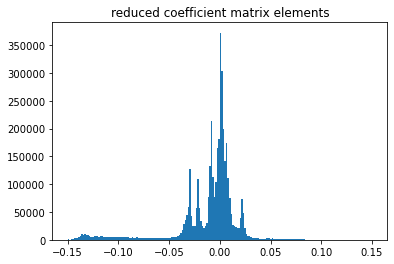

In [13]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-2.8)

# scaler = ELPH_Scaler.standardize_scaler()
scaler = ELPH_Scaler.normalize_scaler(0.3)
# scaler = ELPH_Scaler.tanh_scaler(arg_scale=1.0, out_scale=0.3)

NVAR = SVDNVAR(runs)
NVAR.train(rdim=20, n_VAR_steps=2, NVAR_p=2, intercept=True, optimizer=optimizer, scaler=scaler)
NVAR.print_status()

plt.imshow(NVAR.w, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('NVAR weights')
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(NVAR.w))))
plt.title('sorted NVAR weights')
plt.show()

plt.hist(np.ravel(NVAR.red_coef_matrix), bins=200)
plt.title('reduced coefficient matrix elements')
plt.show()

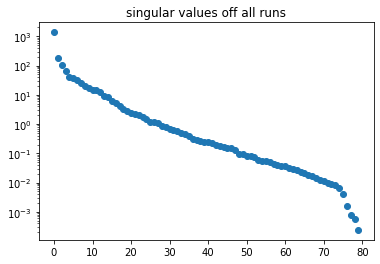

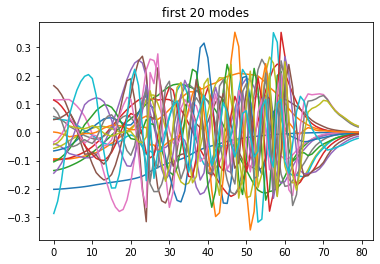

In [14]:
plt.semilogy(NVAR.S, 'o')
plt.title('singular values off all runs')
plt.show()
 
for l in range(NVAR.rdim):
  plt.plot(NVAR.U[:,l],  label='Uhat_'+str(l))
plt.title('first ' + str(NVAR.rdim) + ' modes')
plt.show()

In [15]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-2.8)
scaler = ELPH_Scaler.normalize_scaler(0.3)

train_kwargs = {'rdim':20, 'n_VAR_steps':2, 'NVAR_p':2, 'intercept':True, 'optimizer':optimizer, 'scaler':scaler, 'full_hist':False}
score_kwargs = {'norm':'max', 'errSVD':False}

m,s = ELPH_utils.get_KFold_CV_scores(NVAR, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
print(m)
print(np.std(s))
print(s)

0.028579476079046595
0.004083188549738007
[0.03076735904171452, 0.026505123493502144, 0.027057668405162952, 0.02332690203973165, 0.035240327415121724]


In [16]:
def get_score(aExp, rel_scale):
    alpha = 10.0**aExp
    
    scaler = ELPH_Scaler.normalize_scaler(rel_scale)
    optimizer = ELPH_Optimizer.ridge(alpha=alpha)
    
    train_kwargs = {'rdim':20, 'n_VAR_steps':2, 'NVAR_p':2, 'intercept':True, 'optimizer':optimizer, 'scaler':scaler, 'full_hist':False}
    score_kwargs = {'norm':'max', 'errSVD':True}
    
    m,s = ELPH_utils.get_KFold_CV_scores(NVAR, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
    
    r = -1.*m - 1.*np.std(s)
    if np.isnan(r):
        r = -10.0
    return r

# print(get_score(-3.4, 0.1))

from bayes_opt import BayesianOptimization
pbounds = {'aExp':[-5, -1], 'rel_scale':[0.1,0.7]}
optimizer = BayesianOptimization(f=get_score, pbounds=pbounds, random_state=817)

# optimizer.maximize(init_points=10, n_iter=60)

In [8]:
# scores = []

# k = 1

# for aExp in np.linspace(-4,-2,15):
#     for rs in np.linspace(0.2,0.5,15):
#         print(k)
#         scores.append(get_score(aExp,rs))
#         k += 1

In [9]:
# scrs = np.array(scores)
# scrs = np.reshape(scrs,(15,15))


# plt.imshow(scrs, aspect='auto', origin='lower', vmin=-0.02, extent=[0.2,0.5,-4,-2])
# plt.colorbar()
# plt.show()

rdim:  10
n_VAR_steps:  2
NVAR_p:  2
VAR state shape:  (20, 199101)
NVAR state shape:  (231, 199101)
target shape:  (10, 199101)
weights shape:  (231, 10)
NVAR error:  0.03150498652014688
NVAR error compared to SVD approximated run:  0.029492055933348027


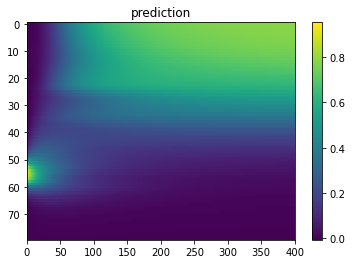

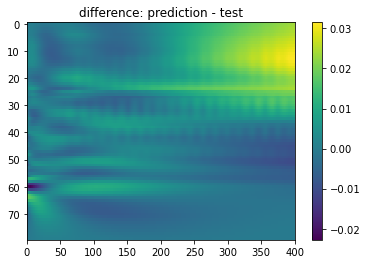

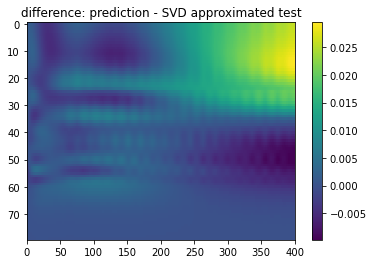

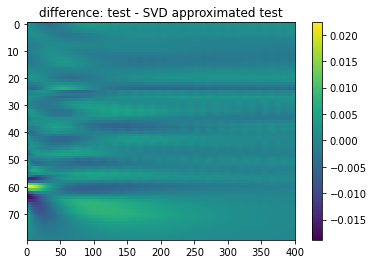

In [33]:
scaler = ELPH_Scaler.normalize_scaler(0.3)
optimizer = ELPH_Optimizer.ridge(alpha=10.**-2.8)
# optimizer = ELPH_Optimizer.lstsqrs()


train_runs = runs[::1]
test_run = train_runs.pop(417)

NVAR.load_runs(train_runs)
NVAR.train(rdim=10, n_VAR_steps=2, NVAR_p=2, intercept=True, optimizer=optimizer, scaler=scaler, full_hist=False)

NVAR.print_status()


print('NVAR error: ', NVAR.get_error(test_run, norm='max') )
print('NVAR error compared to SVD approximated run: ', NVAR.get_error(test_run, norm='max', errSVD=True) )

pred = NVAR.predict_single_run(test_run)
test_run_SVDapprx = NVAR.Uhat @ NVAR.Uhat.T @ test_run


xmax = runs[0].shape[1]

plt.imshow(pred, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('prediction')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - SVD approximated test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(test_run-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: test - SVD approximated test')
plt.xlim(0,xmax)
plt.show()


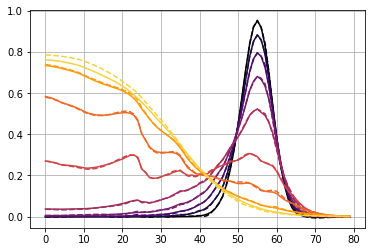

In [34]:
colors = plt.get_cmap('inferno')

tn_arr = [0,2,5,10,20,50,100,200,399]

plt.grid()

for k,tn in enumerate(tn_arr):
    plt.plot(test_run[:,tn], '-', c=colors(k/len(tn_arr)))
    plt.plot(pred[:,tn], '--', c=colors(k/len(tn_arr)))

plt.show()